# HW2 Pattern Recognition
### 2019150445 신백록


<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## 0. Data Preprocessing & Visualization

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test)=mnist.load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

Init Plugin
Init Graph Optimizer
Init Kernel
(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [2]:
unique,counts=np.unique(y_train,return_counts=True)
print('Train labels:',dict(zip(unique,counts)))
unique,counts=np.unique(y_test,return_counts=True)
print('Test labels:',dict(zip(unique,counts)))

Train labels: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


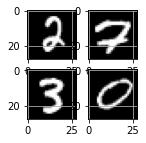

In [3]:
indices=np.random.randint(0,x_train.shape[0],size=4)
images=x_train[indices]
labels=y_train[indices]

plt.figure(figsize=(2,2))
for i in range(len(indices)):
    plt.subplot(2,2,i+1)
    image=images[i]
    plt.imshow(image, cmap='gray')
    plt.grid('off')
plt.show()

#### Randomly select 4 digits & plot

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## 1. PCA with MNIST data

In [4]:
x_train=x_train.reshape(-1,28*28)
x_test=x_test.reshape(-1,28*28)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


#### Reshape (28,28)->728 

In [5]:

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc.fit(x_train)
X_train_std=sc.transform(x_train)

print(np.mean(X_train_std))#Almost 0
print(np.var(X_train_std))#close to 1

-2.1974863349995617e-18
0.9145408163265558


#### Center the data at zero

In [6]:
X_train_cov=np.matmul(X_train_std.T,X_train_std)

#### Compute the covariance matrix

In [7]:
print(X_train_cov.shape)

(784, 784)


In [8]:
eig=np.linalg.eig
eigen_value=eig(X_train_cov)[0]
eigen_vector=eig(X_train_cov)[1]

idx = eigen_value.argsort()[::-1]   
eigen_value = eigen_value[idx]
eigen_vector = eigen_vector[:,idx]

#### Find eigenvector & eigenvalue by covariance matrix & sort by descending way.

In [9]:
print(eigen_value.shape)  
print(eigen_vector.shape)

(784,)
(784, 784)


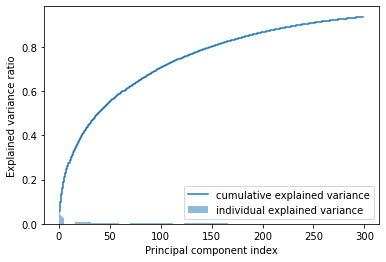

In [10]:
tot=sum(eigen_value)
var_exp=[(i/tot) for i in eigen_value[:299]]
cum_var_exp=np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,300),var_exp,alpha=0.5,align='center',label='individual explained variance')
plt.step(range(1,300),cum_var_exp,where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [11]:
for i in range(len(eigen_value)):
    if sum(eigen_value[:i])/sum(eigen_value)>0.9:
        print(i)
        break

236


#### When we use threshold 0.9, first 236 eigenvectors are used to explain 90% of total variance.
#### But for the convenience of plotting, let's use 16*16=256 eigenvectors

In [12]:
eigendigit_space=eigen_vector[:,:256] 

#### Select 256<<728 eigenvectors with highest eigenvalues

In [13]:
print(eigendigit_space.shape)

(784, 256)


In [14]:
projection=np.matmul(X_train_std,eigendigit_space)

#### Project data points to those eigenvectors

In [15]:
print(projection.shape)

(60000, 256)


In [16]:
print(projection[:10,:5])

[[  0.92215881  -4.81479035  -0.06755984  -8.0513293   -0.9853473 ]
 [ -8.70897698  -7.75440302   3.44791044  -1.66832141   0.83479532]
 [ -2.32838932   9.43133817   6.18411405   1.72506609   4.09245604]
 [  6.58217331  -3.74631834  -3.69085127  -0.46104068   5.62732462]
 [  5.1832512    3.13329712   6.27794746   1.45965399  -1.60884235]
 [ -2.19840211  -3.06836644   0.2312572    2.75260056  -1.21688731]
 [  6.77334369   0.82307934  -2.93236971   0.98851194   1.46036522]
 [ -1.92690853  -5.40626434   0.16303186 -11.1530086   -5.0037197 ]
 [  7.82233526   0.19181     -1.10015127   1.55955849   4.22122044]
 [  3.22762585  -4.72642548   4.28898033   3.63120125  -0.71205431]]


(256, 28, 28)


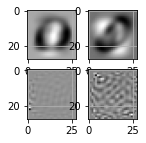

In [17]:
eigendigit=eigendigit_space.T.reshape(256,28,28) #For plotting eigendigits
print(eigendigit.shape)

indices=[0,1,254,255] #Top 2 eigendigits & Last 2 eigendigits
images=eigendigit[indices]
labels=y_train[indices]

plt.figure(figsize=(2,2))
for i in range(len(indices)):
    plt.subplot(2,2,i+1)
    image=images[i]
    plt.imshow(image, cmap='gray')
    plt.grid('off')
plt.show()

#### For the top 2 eigendigits, it seems that some digits are overlapped and that overlapping makes the feature.
#### But for the last 2 eigendigits, we cannot figure out any features through our eyes.
#### Next, let's reconstruct the first data for example.

In [18]:
first_recon=np.mean(x_train)+np.matmul(projection,eigendigit_space.T)[0]

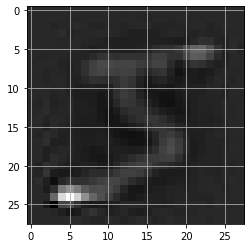

In [19]:
first_recon=first_recon.reshape(28,28) #for plotting

plt.figure()

plt.imshow(first_recon, cmap='gray')
plt.grid('off')
plt.show()

In [20]:
y_train[0]

5

#### The plot exactly seems like 5, and it's 5 actually.
#### And the actual plot looks like this. It's simillar each other.

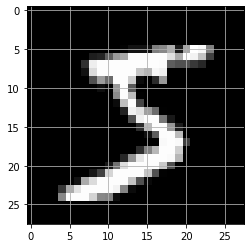

In [21]:
plt.figure()

plt.imshow(x_train[0].reshape(28,28), cmap='gray')
plt.grid('off')
plt.show()

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## 2. Face Recognition steps

Let's say there are M images of size $N X N$. Then the shape of the train set is $(N,N,M)$. Let's call this train set as A.
<br/>

First, we have to flat the data to train. After doing this, the size of the A would be $(N^2,M)$.
<br/>

Next, we have to average the A and the shape of average matrix will be $(N^2,1)$. Let's say this as A_avg
<br/>

With the average matrix, center the data by subtracting the A_avg from A. Let's say this as A_std
<br/>

Since we centered the data, covariance matrix can be computed simply by $AA^T$ and the size of this matrix would be $(N^2,N^2)$. But it's too big to compute. So compute $A^TA$ whose size is (M,M), and obtain eigenvectors of $A^TA, v_i$. then $Av_i$ will be eigen-face space. Let's say that as U whose size is $(N^2,M)$.
<br/>

Select the number of eigenvectors with some criterion. Assume that we select $k<<M$ eigenvectors. Then the size of U would be $(N^2,k)$.
<br/>

Then project the data in eigen-face space by simply computing $U^TA\_std$ and that will be the eigen-face coordinates. Let's say this projection as W whose size is (k,M).
<br/>

We can reconstruct the train data  by $A\_avg +\Sigma(W_k^{(train)} U_k)$.
<br/>

With the test image, normalize the test image by subtracting the $A\_avg$ from train set. Next, project on eigen-space U to obtain the weights for the test image.
<br/>

Then select the argmin i of the euclidean distance between the weights from the train data i & weights from the specific test image. And that test image is recognized as i'th sample from the training set.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## 3. Psedo-code

1. Load the Face train data A that have M images & number of N^2 pixels.

2. If face data has shape of $(N,N,M)$ then
<br/>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; flatten the data to $(N^2,M)$

3. Compute the average of face data along the row axis, $A\_avg$.

4. Compute $A-A\_avg$.

5. If there is many data  (i.e. $N^2<<M$) then
<br/>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Just compute Covariance matrix by $AA^T$.
<br/>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute eigenvalue & eigenvector by covariance matrix.
<br/>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Select $k<<M$ eigenvector by the criterion and call it U.
<br/>
else 
<br/>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute $A^TA$.
<br/>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute eigenvector $v_i$ of $A^TA$.
<br/>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute $Av_i$.
<br/>    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Select $k<<M$ eigenvector by the criterion and call it U.

6. Compute $U^T(A-A\_avg)$ which is the projection of image.

7. We can reconstruct the data by computing $A\_avg+U^T(A-A\_avg)U$.

8. Given an unknown face image, Compute $test-A\_avg$.

9. Compute weights for the test image in eigen-space by $U^T(test-A\_avg)$

10. Compute $dist(U^T(train_i-A\_avg),U^T(test-A\_avg))$ for all ith samples in train set.

11. Test image is recognized as face i which has the minimum distance.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />


## 4. Distinguish MNIST test set

#### This starts at step 8 of psedo-code because I already done step 1 to 7 already in Chapter 1.

In [22]:
sc=StandardScaler()
sc.fit(x_train)
X_test_std=sc.transform(x_test)

#### Center the data by subtracting mean of the train set.

In [23]:
weight_test=np.matmul(X_test_std,eigendigit_space)
print(weight_test.shape)

(10000, 256)


In [24]:
weight_train=projection
print(weight_train.shape)

(60000, 256)


In [25]:
index=[]
for i in range(len(weight_test)):
    dist=[]
    append=dist.append
    for j in range(len(weight_train)):
        append(np.linalg.norm(weight_train[j]-weight_test[i]))
    index.append(np.argmin(dist))

#### Compute all euclidean distances betweein weight_train & weight_test and select the minimum distance.

In [26]:
predicted_y=y_train[index]

In [27]:
sum(y_test==predicted_y)/len(predicted_y) 

0.9513

#### 95.13% accuracy with the test set.